In [1]:
"""
The general method for the ARIMA implementation comes from:

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
"""

'\nThe general method for the ARIMA implementation comes from:\n\nhttps://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7\nhttps://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/\n'

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from sklearn import metrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit

#Imported to ignore warnings from ARIMA
import warnings
warnings.filterwarnings("ignore")

#10 import statements

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#3 lines written by me

In [4]:
def read_data(pathname, indicatorcode):
    df = pd.read_excel(pathname)
    
    df2 = df.loc[df['Indicator Code'] == indicatorcode]
    
    #Dropping these columns as they are not needed for the forecast
    df2 = df2.drop(columns=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
    
    df3 = df2.swapaxes('index', 'columns')
    
    return df3

#6 lines written by me

In [5]:
"""
Method for this block of code is refactored from:

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
"""

def stationarityTest(data):
    
    #Find out if the data is stationary or not
    #Using Rolling Statistics (Rolling Mean and Rolling Std)
    rolling_mean = data.rolling(window=10).mean()
    rolling_std = data.rolling(window=10).std()
    
    plt.plot(data, color='blue', label='original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('RM vs RSTD vs ORI')
    
    #Augmented Dickey-Fuller Test
    result = adfuller(data.dropna())
    print('ADF Statistic: ', result[0])
    print('p-value: ', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
        
#14 lines from guide

In [6]:
"""
Order Differencing inspired from:

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
"""

def make_stationary(data):
    
#1st Order Differencing
    data_first_od = data.diff()
    data_first_od_dropped = data_first_od.dropna(inplace=True)
    
    return data_first_od

In [7]:
def performance_metrics(y_test, y_pred):
    
    sign1 = np.sign(np.array(y_test[1:]) - np.array(y_test[:-1]))
    sign2 = np.sign(np.array(y_pred[1:]) - np.array(y_pred[:-1]))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test )) *100
    mae = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    mda = np.mean((sign1 == sign2).astype(int))
    mean = np.mean(y_test)
    si = (rmse/mean)*100
    
    print("RMSE: ", rmse)
    print("MAPE: ", mape)
    print("MAE: ", mae)
    print("Scatter Index: ", si)
    print("MDA: ", mda)
    print("Mean of actual: ", mean)
    
#16 lines, 9 lines written by me, 4 documentation 3 modi

In [8]:
data = read_data('/Users/farhanhabibie/Desktop/Farhan Thesis Code /UG-Project-Farhan/Indonesia Macro Dataset.xlsx', 
                     'SL.UEM.TOTL.FE.ZS')
data = data.dropna()
data_first_ord = make_stationary(data)
#1 line written by me

ADF Statistic:  -1.4538774558003453
p-value:  0.5561917639892677
Critical Values:
	1%: -3.7238633119999998
	5%: -2.98648896
	10%: -2.6328004


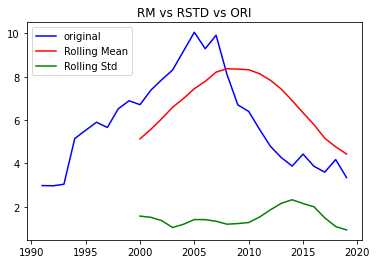

In [9]:
stationarityTest(data)

ADF Statistic:  -6.95836001713392
p-value:  9.301926784256855e-10
Critical Values:
	1%: -3.7238633119999998
	5%: -2.98648896
	10%: -2.6328004


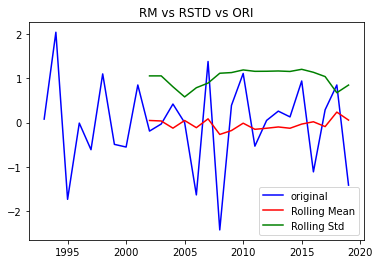

In [10]:
stationarityTest(data_first_ord.diff())

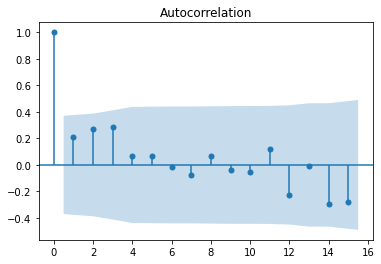

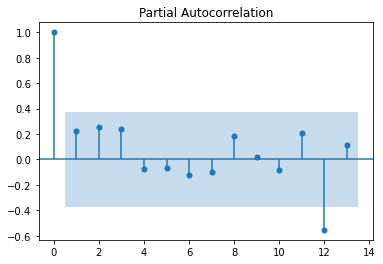

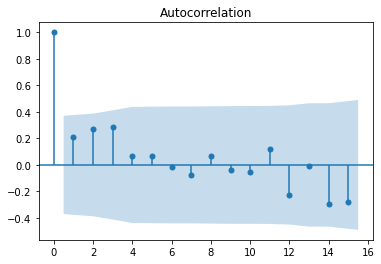

In [11]:
#Find AR order(p), differencing order(d), MA(q)

#Find AR order(p) using a PACF, only considering the 
plot_pacf(data.diff().dropna(), lags=13)

#Find MA order (q) using acf plot
plot_acf(data.diff().dropna())

#2 lines from documentation

In [12]:
train = data[:int(len(data)*0.8)]
test = data[int(len(data)*0.8):]

In [13]:
"""
reused and modified from: 

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
"""

model = ARIMA(train, order=(0,0,0)) 
model = model.fit()
predict = model.predict(start=len(train), end=len(train)+len(test)-1)
#3 lines from guide but modified

RMSE:  2.6246253936212365
MAPE:  68.34397441965821
MAE:  2.6006473832089143
Scatter Index:  67.55792673756189
MDA:  0.0
Mean of actual:  3.884999910990397


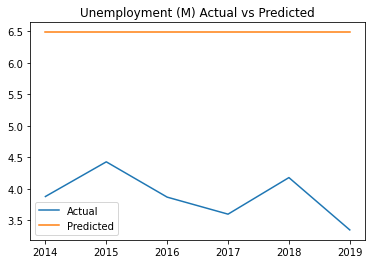

In [14]:
df_compare = pd.DataFrame({'Actual' : test.values.flatten(), 'Predicted' : predict.values})
newindex = test.index.values.tolist()
df_compare.index = newindex
df_compare.plot(title='Unemployment (M) Actual vs Predicted')
performance_metrics(test.values, predict.values)
#4 lines written by me

In [15]:
predict.mean()

6.485647294199311

In [16]:
data.mean()

310    5.947586
dtype: float64

In [17]:
"""
Idea for using pmdarima attributed to the video on youtube:

https://www.youtube.com/watch?v=8FCDpFhd1zk&ab_channel=NachiketaHebbar
"""

autoarima = auto_arima(train,
                       trace=True, d=0, suppress_warnings=True, n_fits=50, test='adf')

autoarima.summary()

#2 lines from youtube

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=61.419, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=102.455, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=64.720, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=155.477, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=65.882, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=65.234, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=66.129, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 0.598 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   23
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 -24.709
Date:                Sun, 01 May 2022   AIC                             61.419
Time:                        02:08:09   BIC                             68.232
Sample:                             0   HQIC                            63.132
                                 - 23                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3597      0.234      1.537      0.124      -0.099       0.818
ar.L1          1.9109      0.078     24.546      0.000       1.758       2.064
ar.L2         -0.9698      0.062    -15.697      0.000      -1.091      -0.849
ma.L1         -1.1249      1.766     -0.637      0.524      -4.586       2.336
ma.L2          0.1439      0.297      0.484      0.628      -0.438       0.726
sigma2         0.4001      0.662      0.604      0.546      -0.898       1.698
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.93
Prob(Q):                              0.92   Prob(JB):                         0.63
Heteroskedasticity (H):               0.71   Skew:                             0.48
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
"""
64 Lines of code
"""

'\n83 Lines of code\n'